In [1]:
"""
Random forest Experiments Serrano/AUDSOME Phase 1
Anomaly Only
Gabriel Iuhasz
"""
import numpy as np
np.random.seed(42)
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, accuracy_score, jaccard_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

import xgboost as xgb
# from sklearn.externals import joblib
from joblib import dump, load
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from tune_sklearn import TuneSearchCV
from subprocess import check_output
%matplotlib inline

In [2]:
def custom_scoring_reporting(y_pred,
                             y,
                             definitions,
                             prefix):
    """
    Custom function for handling scoring and reporting
    :param y_pred: model predictions
    :param y: ground truth
    :param definitions: variable class definitions (factorize)
    :param prefix: prefix to saved files and images
    :return: 0
    """
    print("Accuracy score is: {}".format(accuracy_score(y, y_pred)))
    print("Ballanced accuracy score is: {}".format(balanced_accuracy_score(y, y_pred)))
    print("Jaccard score (micro): {}".format(jaccard_score(y, y_pred, average='micro')))
    print("Jaccard score (macro): {}".format(jaccard_score(y, y_pred, average='macro')))
    print("Jaccard score (weighted): {}".format(jaccard_score(y, y_pred, average='weighted')))


    print("Full classification report")
    print(classification_report(y, y_pred, target_names=definitions))
    report = classification_report(y, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    classification_rep_name = "{}_classification_rep_best.csv".format(prefix)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)


    print("Imbalanced Classification report")
    print(classification_report_imbalanced(y, y_pred, target_names=definitions))
    imb_report = classification_report_imbalanced(y, y_pred, target_names=definitions, output_dict=True)
    df_imb_classification_report = pd.DataFrame(imb_report).transpose()
    classification_imb_rep_name = "{}_imb_classification_rep_best.csv".format(prefix)
    df_imb_classification_report.to_csv(os.path.join(model_dir,classification_imb_rep_name), index=False)



Common preprocessing for all experiments

In [3]:
print("Checking files in data location ...")
train_dir = '/Users/Gabriel/Dropbox/Research/ASPIDE/Datasets/ECI Chaos/Distributed Phase 1/finalized/single_node/training'
# train_dir = '/home/gabriel/Research/Aspide/workspace/data_phase'
# train_dir = '/home/gabriel/research/dipet/serrano/data'
print(check_output(["ls", train_dir]).decode("utf8"))

Checking files in data location ...
data
df_anomaly.csv
df_audsome.csv
df_clean_ausdome_single.csv
df_clean_single.csv
models
processed



In [4]:
print("Setting paths and datasets")
# Checking if directory exists for data, modells and processed

data_dir = os.path.join(train_dir,'data')
model_dir = os.path.join(train_dir,'models')
processed_dir = os.path.join(train_dir,'processed')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# if not os.path.exists(processed_dir):
#     os.makedirs(processed_dir)

Setting paths and datasets


In [5]:
df_anomaly = pd.read_csv(os.path.join(train_dir,"df_anomaly.csv"))
df_audsome = pd.read_csv(os.path.join(train_dir,"df_audsome.csv"))
df_clean = pd.read_csv(os.path.join(train_dir,"df_clean_single.csv"))
df_clean_audsome = pd.read_csv(os.path.join(train_dir,"df_clean_ausdome_single.csv"))

# Set index as time
df_anomaly.set_index('time', inplace=True)
df_audsome.set_index('time', inplace=True)
df_clean.set_index('time', inplace=True)
df_clean_audsome.set_index('time', inplace=True)

In [6]:
print("Dataset chosen ...")
data = df_anomaly

# Nice print
nice_y = data['target']


Dataset chosen ...


In [7]:
# Uncomment for removing dummy TODO CHECK if adding back dummy
# data.loc[data.target == "dummy", 'target'] = "0"

#Creating the dependent variable class
factor = pd.factorize(data['target'])
data.target = factor[0]
definitions = factor[1]
# print(data.target.head())
# print(definitions)

In [8]:
print("Splitting dataset into training and ground truth ...")
X = data.drop('target', axis=1)
y = data['target']

Splitting dataset into training and ground truth ...


Ploting class distribution ..


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


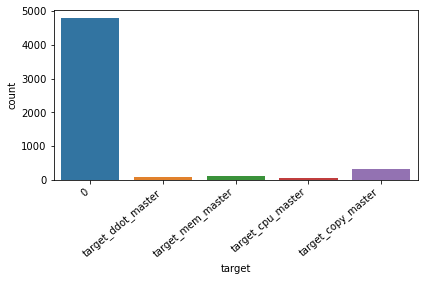

In [9]:
# Plot class distribution
print("Ploting class distribution ..")
pltdist= sns.countplot(nice_y)
pltdist.set_xticklabels(pltdist.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [10]:
print("Scaling dataset")
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) # transform back to df

Scaling dataset


Starting of experiment for RandomForest only

In [11]:
# Name of experiment
# RandomForest
prefix = 'Phase1_RF_tune_skopt_e1'
paramgrid = {
    "n_estimators": [10, 50, 100, 200, 300, 500, 1000], # if early stopping used n_estimators not settable?
    "max_depth": [5, 10, 25, 50, None],
    "max_features": ['sqrt', 'auto', 'log2'],
    "min_samples_split":[2, 5, 11],
    "min_samples_leaf":[1, 5, 11],
    "criterion": ['entropy', 'gini'],
    "random_state": [42]
}
model = RandomForestClassifier()

In [12]:
#Tune

scorer = make_scorer(jaccard_score, average="micro") # TODO check average
n_splits = 4 # default 4
cv_type = StratifiedKFold(n_splits=n_splits)

cv = TuneSearchCV(model,
                   param_distributions=paramgrid,
                   # early_stopping=True,
                   scoring=scorer,
                   cv= cv_type,
                   n_trials=100,
                   max_iters=30,
                   n_jobs=-1,
                   verbose=1,
                   local_dir=model_dir,
                   name=prefix,
                   loggers=["csv"],
                   search_optimization="bayesian",
                  # search_optimization="hyperopt"
)

/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tune_sklearn/tune_basesearch.py:400: UserWarning: max_iters is set > 1 but incremental/partial training is not enabled. To enable partial training, ensure the estimator has `partial_fit` or `warm_start` and set `early_stopping=True`. Automatically setting max_iters=1.
  warnings.warn(


In [13]:
cv.fit(X, y)

TuneSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             local_dir='/Users/Gabriel/Dropbox/Research/ASPIDE/Datasets/ECI '
                       'Chaos/Distributed Phase '
                       '1/finalized/single_node/training/models',
             loggers=[<class 'ray.tune.logger.CSVLogger'>,
                      <class 'ray.tune.logger.JsonLogger'>],
             mode='max', n_jobs=-1, n_trials...
             param_distributions={'criterion': ['entropy', 'gini'],
                                  'max_depth': [5, 10, 25, 50, None],
                                  'max_features': ['sqrt', 'auto', 'log2'],
                                  'min_samples_leaf': [1, 5, 11],
                                  'min_samples_split': [2, 5, 11],
                                  'n_estimators': [10, 50, 100, 200, 300, 500,
                                                   1000],
                          

In [14]:
# Remove bool values from dict
# cv.cv_results_.pop('nan_test_score?')

print("Saving CV results")
file_name = "{}_hpo_best_cv.csv".format(prefix)
# with open(os.path.join(model_dir,file_name), 'w') as cvfile:
#     json.dump(cv.cv_results_, cvfile)
cv_test_scores = pd.DataFrame(cv.cv_results_)
cv_test_scores.to_csv(os.path.join(model_dir,file_name), index=False)
print("{} best params: {}".format(prefix, cv.best_params_))
param_name = "{}_hpo_best_param.json".format(prefix)
with open(os.path.join(model_dir,param_name), 'w') as cvfile:
    json.dump(cv.best_params_, cvfile)
print("{} best score: {}".format(prefix, cv.best_score_))
print("Saving best {} estimator".format(prefix))
model_name = "{}_hpo_best.joblib".format(prefix)
dump(cv.best_estimator_, os.path.join(model_dir,model_name))

Saving CV results
Phase1_RF_tune_skopt_e1 best params: {'n_estimators': 100, 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 11, 'criterion': 'entropy', 'random_state': 42}
Phase1_RF_tune_skopt_e1 best score: 0.9792964463013727
Saving best Phase1_RF_tune_skopt_e1 estimator


['/Users/Gabriel/Dropbox/Research/ASPIDE/Datasets/ECI Chaos/Distributed Phase 1/finalized/single_node/training/models/Phase1_RF_tune_skopt_e1_hpo_best.joblib']

In [15]:
y_pred = cv.best_estimator_.predict(X)
custom_scoring_reporting(y_pred, y, definitions, prefix)


Accuracy score is: 0.9948148148148148
Ballanced accuracy score is: 0.9601020445951836
Jaccard score (micro): 0.9896831245394252
Jaccard score (macro): 0.9313050719772473
Jaccard score (weighted): 0.9898967803224559
Full classification report
                    precision    recall  f1-score   support

                 0       1.00      1.00      1.00      4792
target_ddot_master       0.94      0.97      0.95        91
 target_mem_master       0.96      0.96      0.96       132
 target_cpu_master       0.95      0.91      0.93        64
target_copy_master       0.99      0.97      0.98       321

          accuracy                           0.99      5400
         macro avg       0.97      0.96      0.96      5400
      weighted avg       0.99      0.99      0.99      5400

Imbalanced Classification report
                          pre       rec       spe        f1       geo       iba       sup

                 0       1.00      1.00      0.98      1.00      0.99      0.98      4792
t

Confusion matrix


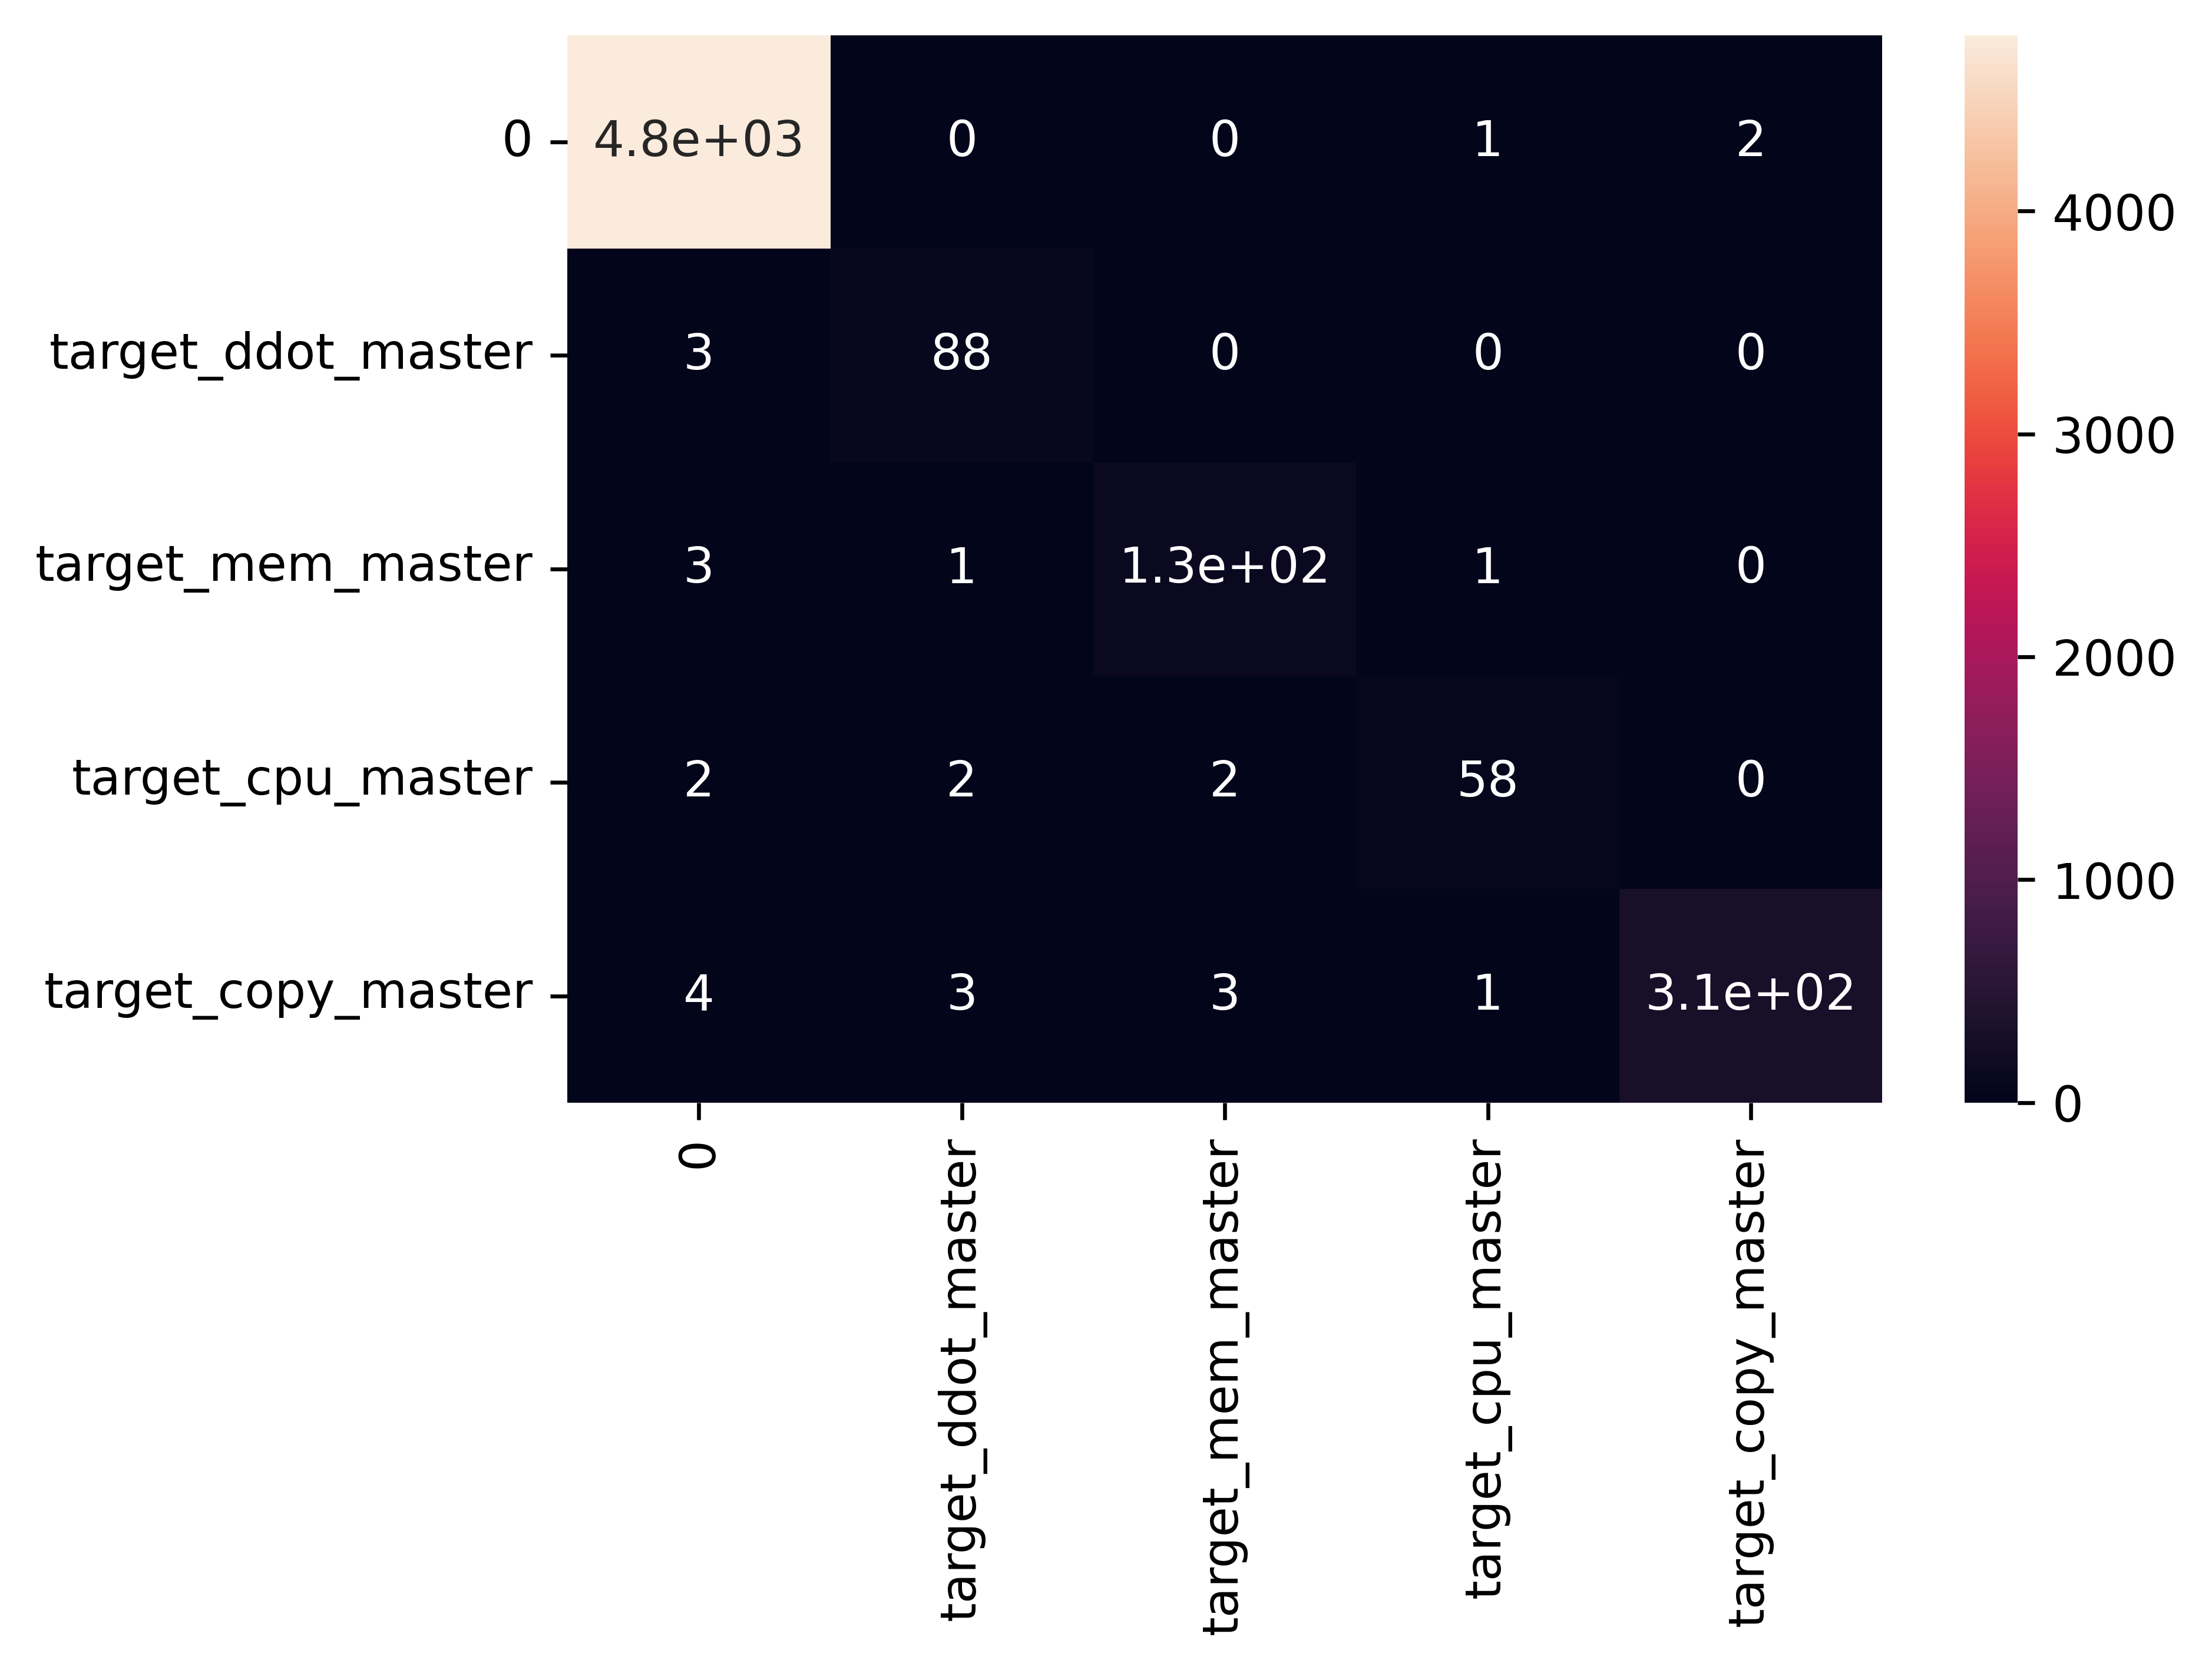

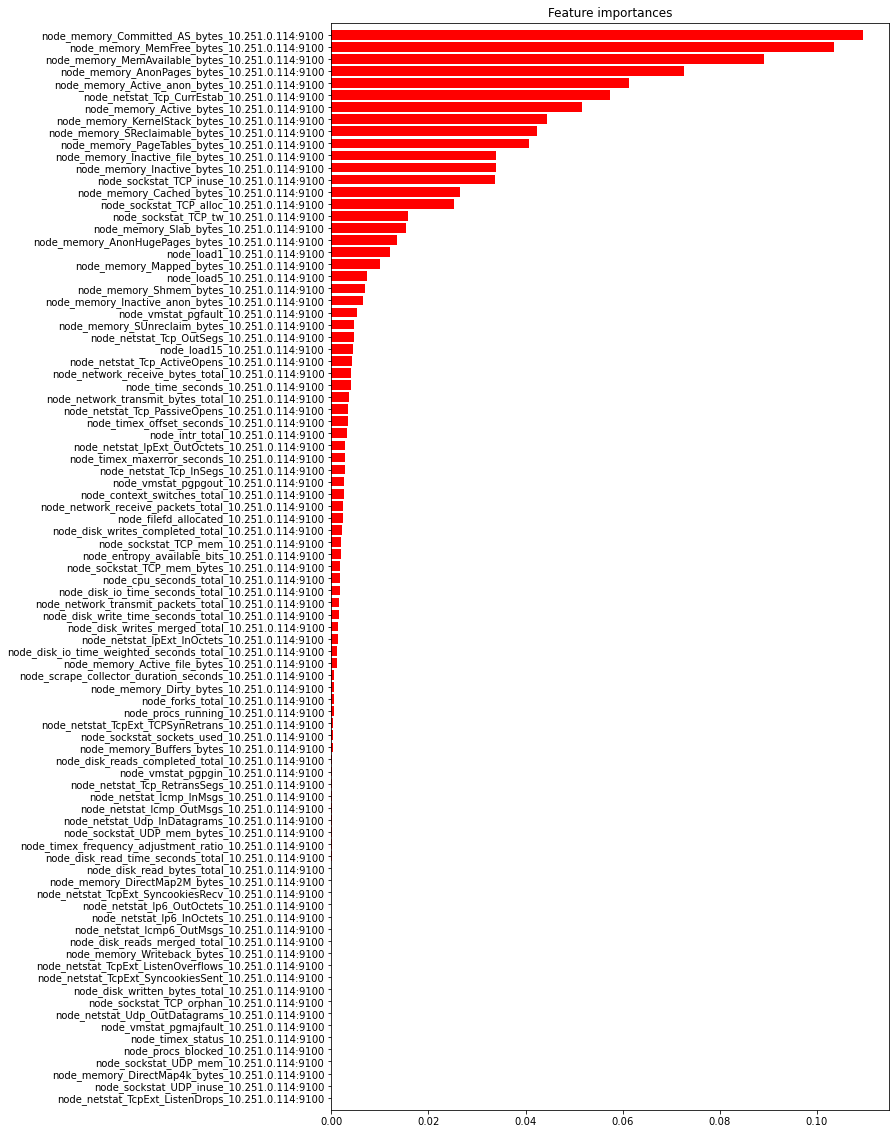

In [16]:
print("Confusion matrix")
cf_matrix = confusion_matrix(y, y_pred)
plt.figure(dpi=600)
sns_cf = sns.heatmap(cf_matrix, annot=True, yticklabels=list(definitions), xticklabels=list(definitions))
cf_fig = "{}_cf.png".format(prefix)
sns_cf.figure.savefig(os.path.join(model_dir, cf_fig), format='pdf',
           bbox_inches='tight', pad_inches=0)

# Extract Feature importance
feat_importances = pd.Series(cv.best_estimator_.feature_importances_, index=list(data.drop('target', axis=1).columns))
featureimp_name = "{}_hpo_best_featureimp.csv".format(prefix)
feat_importances.to_csv(os.path.join(model_dir, featureimp_name), index=True)
# print(feat_importances.head(10))
sorted_feature = feat_importances.sort_values(ascending=True)
# Plot the feature importances of the forest
# plt.figure()
plt.figure(figsize=(10,20))
plt.title("Feature importances")
plt.barh(range(X.shape[1]), sorted_feature,
       color="r", align="center", )
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), sorted_feature.index)
plt.ylim([-1, X.shape[1]])
plt.show()


Scoring on holdout or other dataset

In [1]:
#Creating the dependent variable class
# factor_h = pd.factorize(df_clean['target'])
# df_clean.target = factor_h[0]
# definitions_h = factor_h[1]

In [2]:
# print("Splitting dataset into data and ground truth ...")
# X_h = df_clean.drop('target', axis=1)
# y_h = df_clean['target']

# Scale
# X_h

In [3]:
# X_h = scaler.transform(X_h)


In [4]:
# y_pred_h = cv.best_estimator_.predict(X_h)
#
# custom_scoring_reporting(y_pred_h, y_h, definitions, prefix="rf_holdout")

In [84]:
# y_pred = cv.best_estimator_.predict(X)
# custom_scoring_reporting(y_pred, y, definitions, prefix)

# jaccard_score(y_h, y_pred_h, average='micro')
# y_pred_h